In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("data/X_train/clinical_train.csv")
df_eval = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("data/X_train/molecular_train.csv")
maf_eval = pd.read_csv("data/X_test/molecular_test.csv")

target_df = pd.read_csv("data/target_train.csv")
target_df_test = pd.read_csv("data/random_submission_FRacdcw_v9kP4pP.csv")


In [6]:
from src.preprocess import parse_cytogenetics_column

df = df[['CYTOGENETICS']]
cyto = parse_cytogenetics_column(df.reset_index(drop=True), column_name='CYTOGENETICS')

In [11]:
cyto.iloc[15]

num_subclones                                                         2
sex                                                                 0.0
avg_chromosomes                                                    45.5
total_mitoses                                                        11
num_translocations                                                    1
num_deletions                                                         0
num_inversions                                                        0
num_duplications                                                      0
num_additions                                                         1
num_monosomies                                                        0
num_trisomies                                                         0
complexity_score                                                      2
CYTO                  45,xx,dic(5;17)(q13;p11.2),add(7)(q11.2),der(1...
Name: 15, dtype: object

In [18]:
print(maf_df.skew())

TypeError: could not convert string to float: 'P100000'

In [20]:


# Filtre les colonnes qui sont des float
float_columns = maf_df.select_dtypes(['float64']).columns

maf_df[float_columns].skew()

START    0.584244
END      0.584244
VAF      0.660696
DEPTH    1.252977
dtype: float64

In [30]:
# Filtre les colonnes qui sont des float
cat_columns = df.select_dtypes(['object']).columns

In [62]:
# Merge CENTER column via ID on ID of maf_df
maf_df_center = pd.merge(df[['ID', 'CENTER']], maf_df, on='ID')


In [63]:
maf_df_center.columns

Index(['ID', 'CENTER', 'CHR', 'START', 'END', 'REF', 'ALT', 'GENE',
       'PROTEIN_CHANGE', 'EFFECT', 'VAF', 'DEPTH'],
      dtype='object')

In [64]:
# Do a df['CENTER'].value_counts() and pct 

# Merge CENTER column via ID on ID of maf_df
maf_df_center = pd.merge(df[['ID', 'CENTER']], maf_df, on='ID')


test = pd.DataFrame(maf_df_center['CENTER'].value_counts())
test['pct'] = test['count']/test['count'].sum()*100

# Calculer les valeurs manquantes par centre pour chaque colonne
missing_by_center = {}

for center in maf_df_center['CENTER'].unique():
    center_data = maf_df_center[maf_df_center['CENTER'] == center][['CHR', 'START', 'END', 'REF', 'ALT', 'GENE',
       'PROTEIN_CHANGE', 'EFFECT', 'VAF', 'DEPTH']]
    missing_pct = (center_data.isna().sum() / len(center_data) * 100).round(2)
    missing_by_center[center] = missing_pct

# Créer un DataFrame avec les pourcentages de valeurs manquantes
missing_df = pd.DataFrame(missing_by_center)

# Fusionner avec le DataFrame existant
test = test.join(missing_df.T)

# Trier les colonnes pour avoir count et pct en premier
cols = ['count', 'pct'] + [col for col in test.columns if col not in ['count', 'pct']]
test = test[cols]

# Afficher le résultat
print(test)

        count        pct   CHR  START   END   REF   ALT  GENE  PROTEIN_CHANGE  \
CENTER                                                                          
KI       2851  26.072245  1.05   1.05  1.05  1.05  1.05   0.0            0.21   
DUS      1545  14.128944  1.17   1.17  1.17  1.17  1.17   0.0            0.06   
PV       1067   9.757659  0.56   0.56  0.56  0.56  0.56   0.0            0.19   
GESMD     881   8.056699  0.68   0.68  0.68  0.68  0.68   0.0            0.00   
RMCN      689   6.300869  0.58   0.58  0.58  0.58  0.58   0.0            0.00   
CCH       447   4.087791  3.13   3.13  3.13  3.13  3.13   0.0            0.00   
ROM       336   3.072702  0.60   0.60  0.60  0.60  0.60   0.0            0.00   
MUV       314   2.871513  1.91   1.91  1.91  1.91  1.91   0.0            0.00   
HMS       313   2.862369  2.56   2.56  2.56  2.56  2.56   0.0            0.00   
UOB       304   2.780064  0.99   0.99  0.99  0.99  0.99   0.0            0.00   
CGM       296   2.706904  0.

In [65]:
# Do a df['CENTER'].value_counts() and pct 

# Merge CENTER column via ID on ID of maf_df
maf_df_center = pd.merge(df_eval[['ID', 'CENTER']], maf_eval, on='ID')


test = pd.DataFrame(maf_df_center['CENTER'].value_counts())
test['pct'] = test['count']/test['count'].sum()*100

# Calculer les valeurs manquantes par centre pour chaque colonne
missing_by_center = {}

for center in maf_df_center['CENTER'].unique():
    center_data = maf_df_center[maf_df_center['CENTER'] == center][['CHR', 'START', 'END', 'REF', 'ALT', 'GENE',
       'PROTEIN_CHANGE', 'EFFECT', 'VAF', 'DEPTH']]
    missing_pct = (center_data.isna().sum() / len(center_data) * 100).round(2)
    missing_by_center[center] = missing_pct

# Créer un DataFrame avec les pourcentages de valeurs manquantes
missing_df = pd.DataFrame(missing_by_center)

# Fusionner avec le DataFrame existant
test = test.join(missing_df.T)

# Trier les colonnes pour avoir count et pct en premier
cols = ['count', 'pct'] + [col for col in test.columns if col not in ['count', 'pct']]
test = test[cols]

# Afficher le résultat
print(test)

        count    pct   CHR  START   END   REF   ALT  GENE  PROTEIN_CHANGE  \
CENTER                                                                      
KYW      3089  100.0  2.23   2.23  2.23  2.23  2.23   0.0            1.49   

        EFFECT  VAF  DEPTH  
CENTER                      
KYW       2.91  0.0   2.23  


In [21]:
df_eval.isna().sum() 

ID                0
CENTER            0
BM_BLAST        115
WBC             112
ANC             141
MONOCYTES       883
HB              111
PLT             115
CYTOGENETICS    116
dtype: int64

In [46]:
df.columns

Index(['ID', 'CENTER', 'BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT',
       'CYTOGENETICS'],
      dtype='object')

In [39]:
test

,count
CENTER,
KI,900
DUS,455
PV,316
GESMD,246
RMCN,199
CCH,159
CGM,107
ROM,104
UOB,88


/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_17833/3683320574.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='BM_BLAST', ax=ax[0], shade=True, color="steelblue")
/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_17833/3683320574.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x=np.log(df['BM_BLAST'] + 1), ax=ax[1], shade=True, color="seagreen")


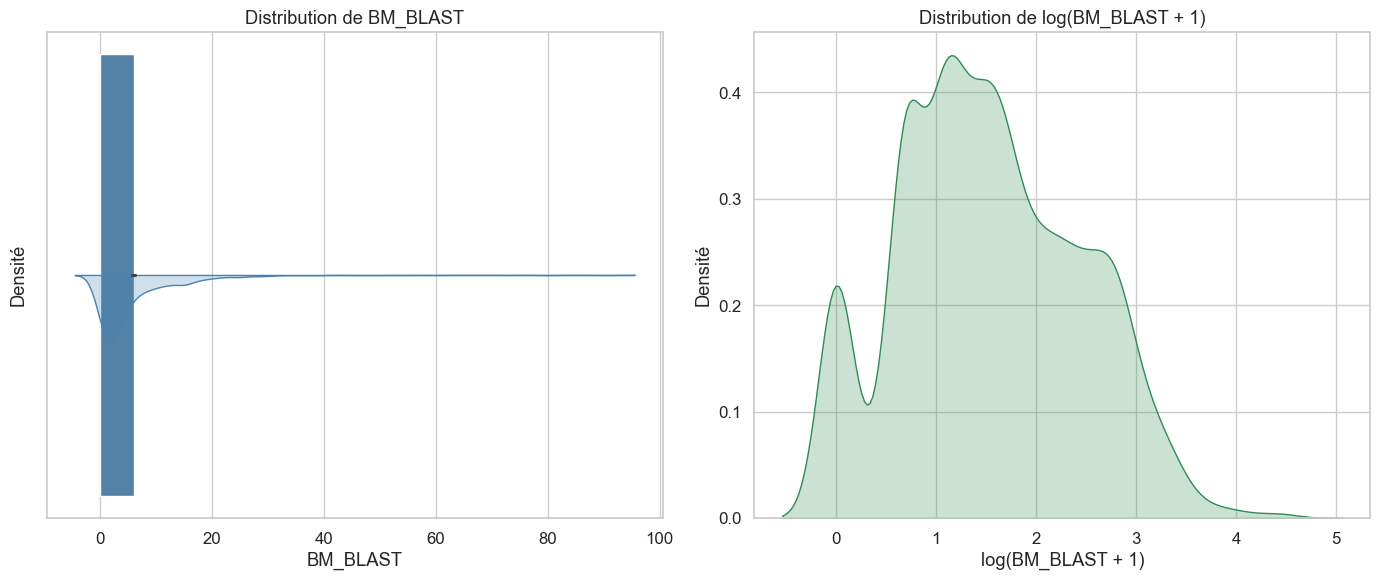

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que df est votre DataFrame contenant la colonne 'BM_BLAST'
sns.set(style="whitegrid", font_scale=1.1)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Graphique KDE pour BM_BLAST d'origine
sns.barplot(data=df, x='BM_BLAST', ax=ax[0], color="steelblue", )
sns.kdeplot(data=df, x='BM_BLAST', ax=ax[0], shade=True, color="steelblue")

ax[0].set_title("Distribution de BM_BLAST")
ax[0].set_xlabel("BM_BLAST")
ax[0].set_ylabel("Densité")

# Graphique KDE pour la transformation log de BM_BLAST
sns.kdeplot(data=df, x=np.log(df['BM_BLAST'] + 1), ax=ax[1], shade=True, color="seagreen")
ax[1].set_title("Distribution de log(BM_BLAST + 1)")
ax[1].set_xlabel("log(BM_BLAST + 1)")
ax[1].set_ylabel("Densité")

plt.tight_layout()
plt.show()


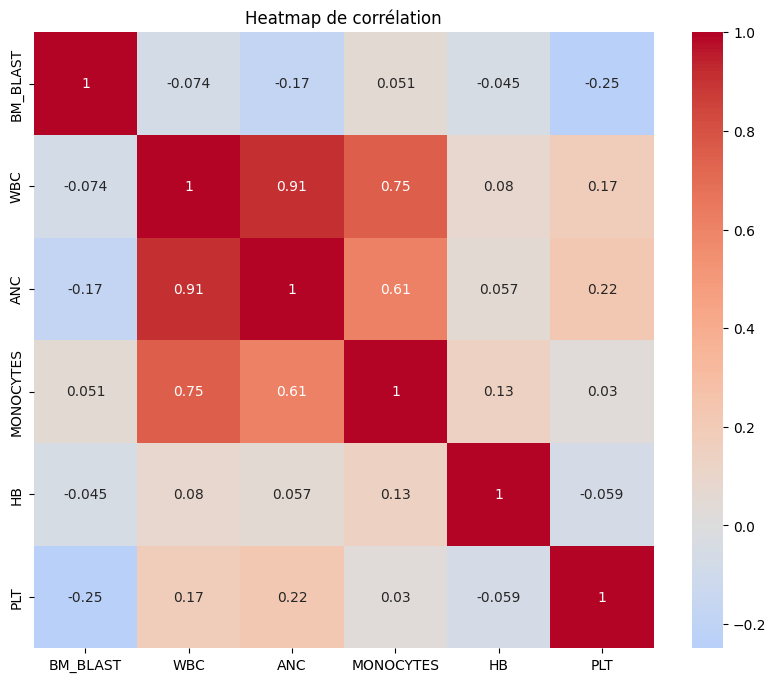

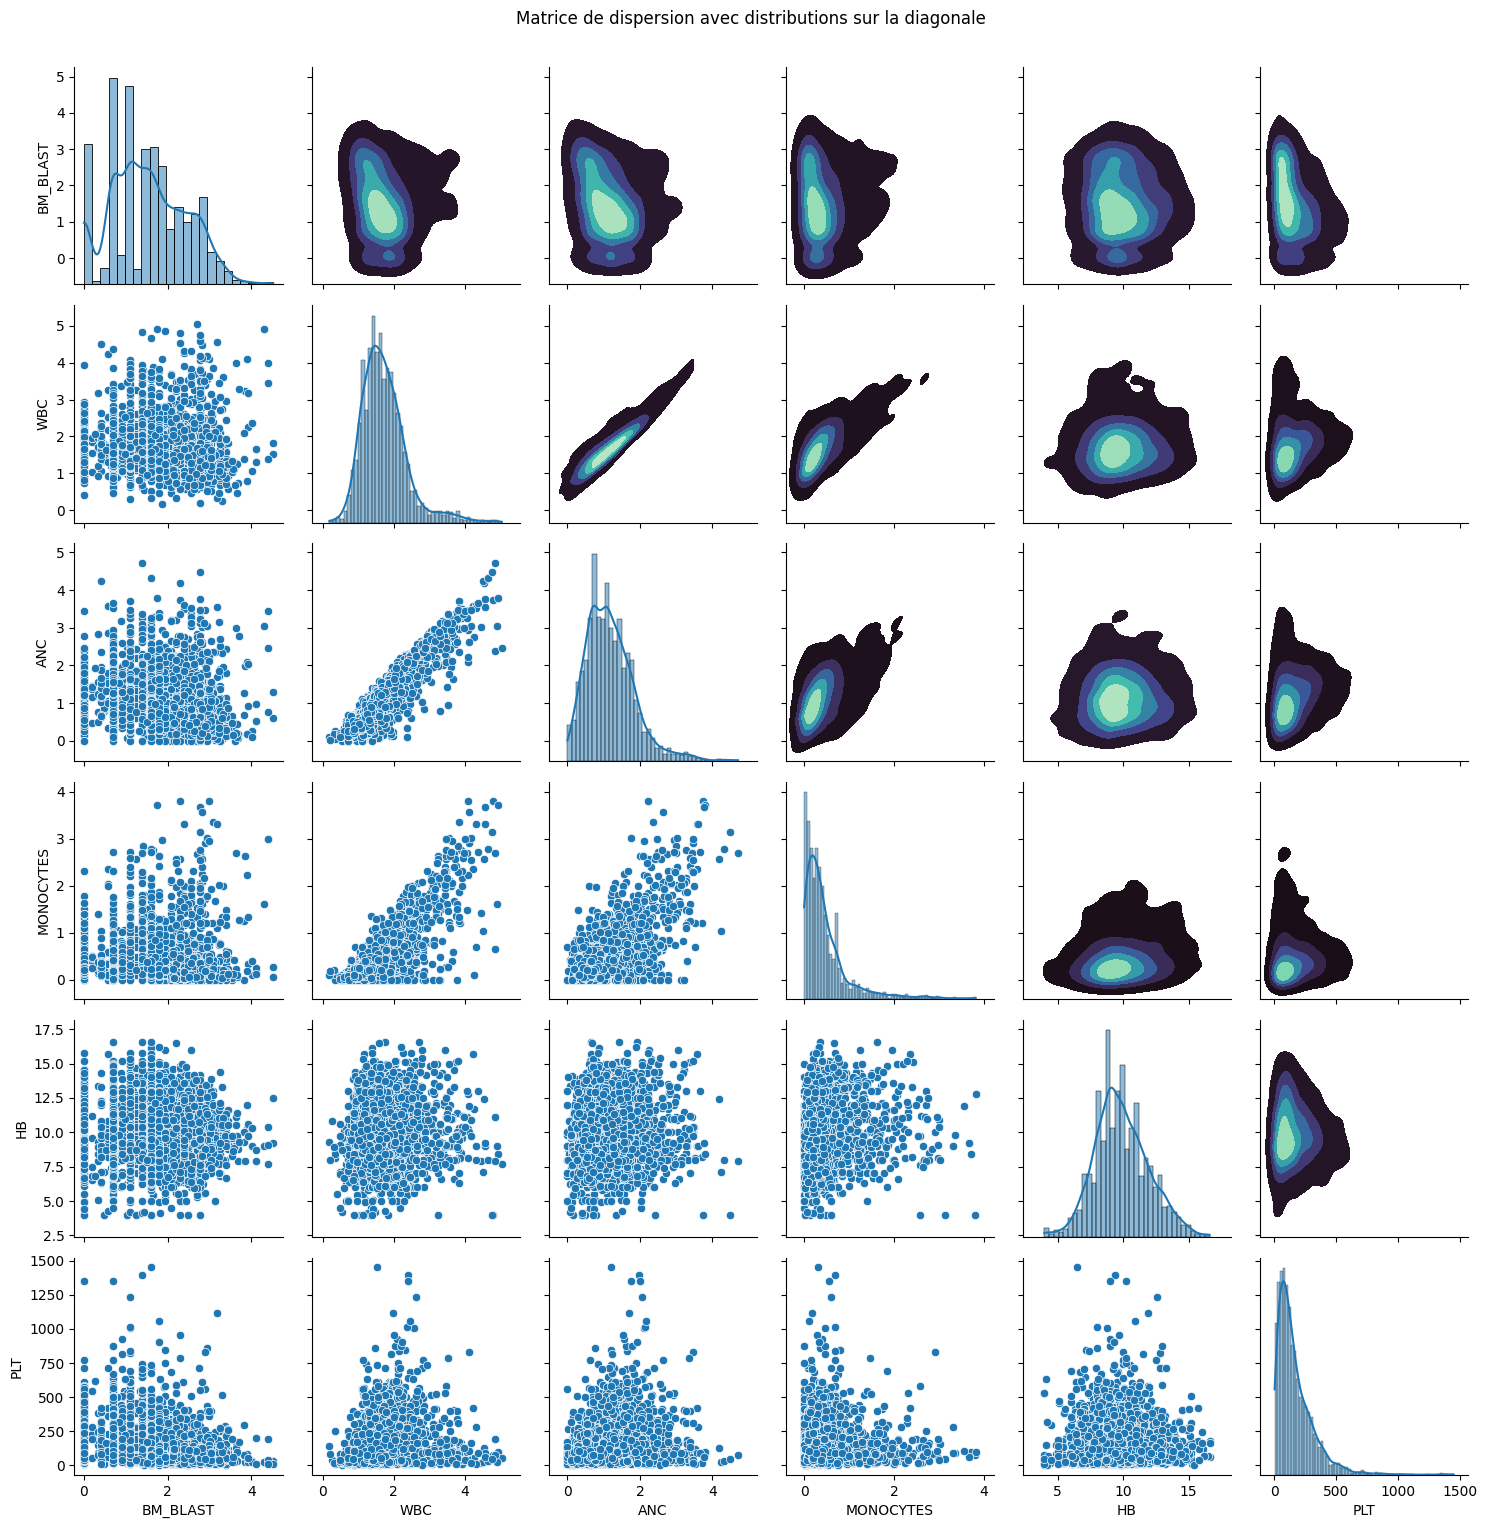

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de DataFrame (à remplacer par votre df)
# df = pd.read_csv("votre_fichier.csv")

# Filtrer les colonnes de type float
float_columns = df.select_dtypes(['float64']).columns

# Passe en log les 4 premières colonne
df[float_columns[:4]] = np.log1p(df[float_columns[:4]])

# 1. Heatmap de corrélation
corr = df[float_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap de corrélation")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.PairGrid(df[float_columns], diag_sharey=False)
g.map_lower(sns.scatterplot)
# Option 1 : Utiliser moins de niveaux et supprimer thresh
g.map_upper(sns.kdeplot, fill=True, levels=6, cmap="mako")
# Option 2 : Supprimer thresh et levels
# g.map_upper(sns.kdeplot, fill=True, cmap="mako")
g.map_diag(sns.histplot, kde=True)

plt.suptitle("Matrice de dispersion avec distributions sur la diagonale", y=1.02)
plt.show()

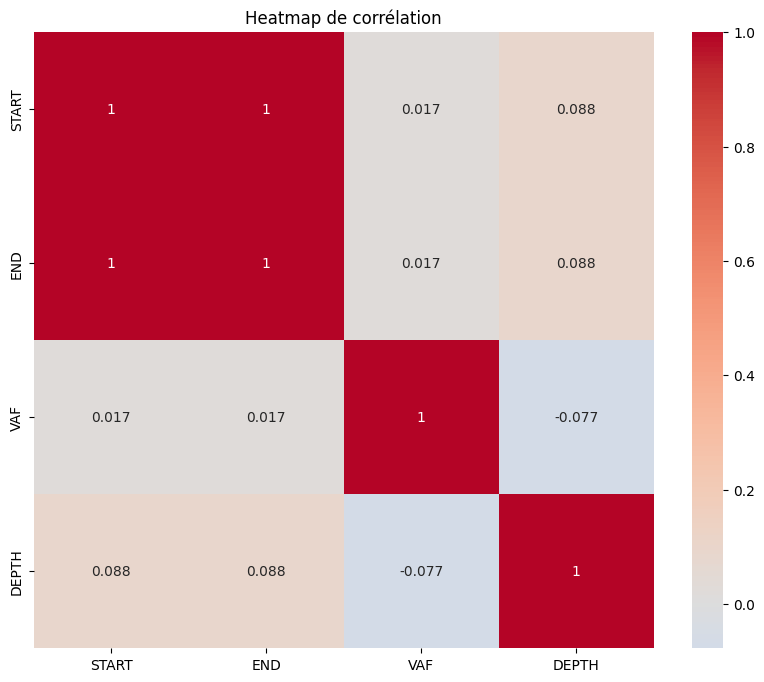

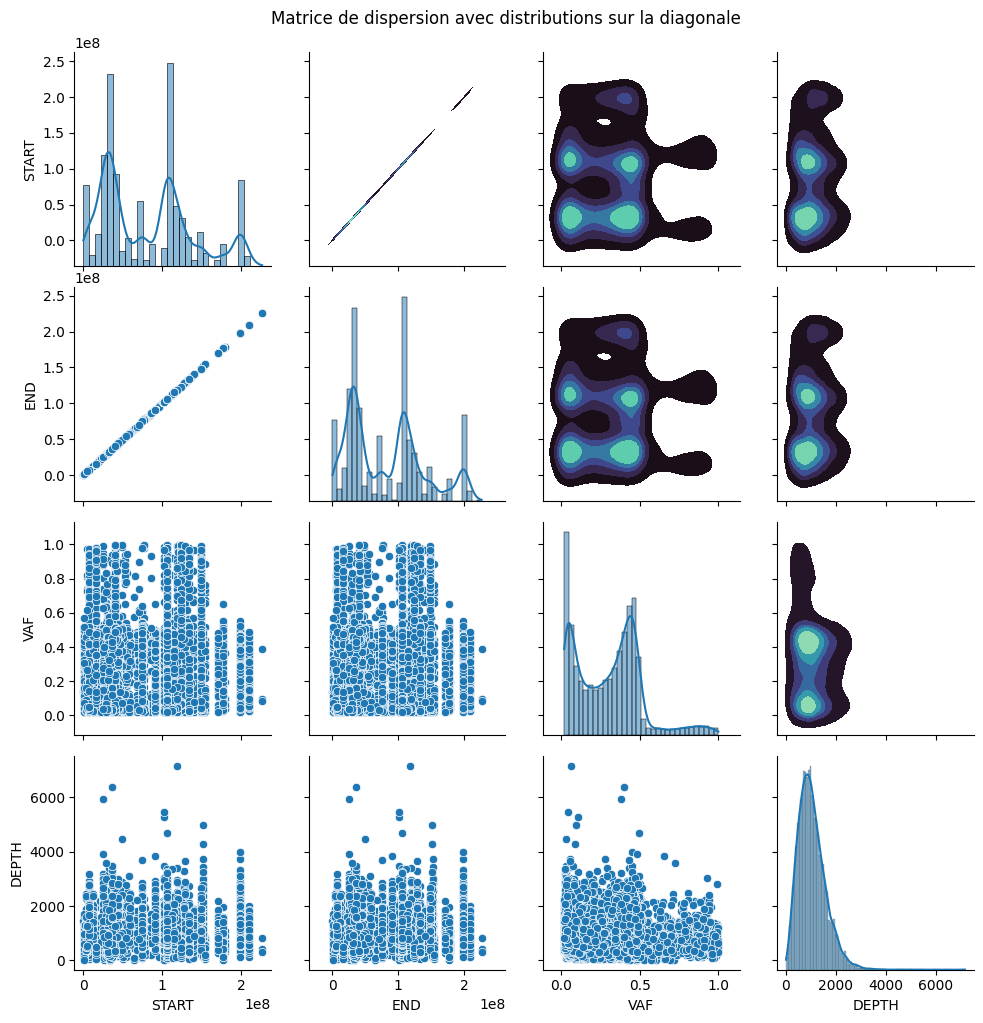

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de DataFrame (à remplacer par votre df)
# df = pd.read_csv("votre_fichier.csv")

# Filtrer les colonnes de type float
float_columns = maf_df.select_dtypes(['float64']).columns

# 1. Heatmap de corrélation
corr = maf_df[float_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap de corrélation")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.PairGrid(maf_df[float_columns], diag_sharey=False)
g.map_lower(sns.scatterplot)
# Option 1 : Utiliser moins de niveaux et supprimer thresh
g.map_upper(sns.kdeplot, fill=True, levels=6, cmap="mako")
# Option 2 : Supprimer thresh et levels
# g.map_upper(sns.kdeplot, fill=True, cmap="mako")
g.map_diag(sns.histplot, kde=True)

plt.suptitle("Matrice de dispersion avec distributions sur la diagonale", y=1.02)
plt.show()

In [22]:
# Do a df of missing values in absolute and pct
missing_values = maf_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
missing_values = missing_values.reset_index()
missing_values.columns = ['Feature', 'Missing_Values']
missing_values['Pct'] = missing_values['Missing_Values'] / maf_df.shape[0]

print(missing_values)

          Feature  Missing_Values       Pct
0             CHR             114  0.010425
1           START             114  0.010425
2             END             114  0.010425
3             REF             114  0.010425
4             ALT             114  0.010425
5           DEPTH             114  0.010425
6             VAF              89  0.008139
7  PROTEIN_CHANGE              12  0.001097


In [66]:
# Do a df of missing values in absolute and pct
missing_values = maf_eval.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
missing_values = missing_values.reset_index()
missing_values.columns = ['Feature', 'Missing_Values']
missing_values['Pct'] = missing_values['Missing_Values'] / df.shape[0]

print(missing_values)

          Feature  Missing_Values       Pct
0          EFFECT              90  0.027084
1             CHR              69  0.020764
2           START              69  0.020764
3             END              69  0.020764
4             REF              69  0.020764
5             ALT              69  0.020764
6           DEPTH              69  0.020764
7  PROTEIN_CHANGE              46  0.013843


Shape des données cliniques : (3323, 9)
Shape des données moléculaires : (10935, 11)

Aperçu des données cliniques :


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"



Info sur les données cliniques :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB

Statistiques descriptives (cliniques) :


,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
count,3214.000000,3051.000000,3130.000000,2722.000000,3213.000000,3199.000000
mean,5.982545,6.535164,3.264735,0.955868,9.893549,167.048900
std,7.615439,10.247219,5.237043,2.666478,2.041158,149.477031
min,0.000000,0.200000,0.000000,0.000000,4.000000,2.000000
25%,1.000000,2.700000,1.000000,0.150000,8.500000,65.500000
50%,3.000000,4.100000,2.000000,0.370000,9.700000,123.000000
75%,8.000000,6.655000,3.690000,0.783000,11.200000,229.500000
max,91.000000,154.400000,109.620000,44.200000,16.600000,1451.000000



Valeurs manquantes dans les données cliniques :
ID                0
CENTER            0
BM_BLAST        109
WBC             272
ANC             193
MONOCYTES       601
HB              110
PLT             124
CYTOGENETICS    387
dtype: int64


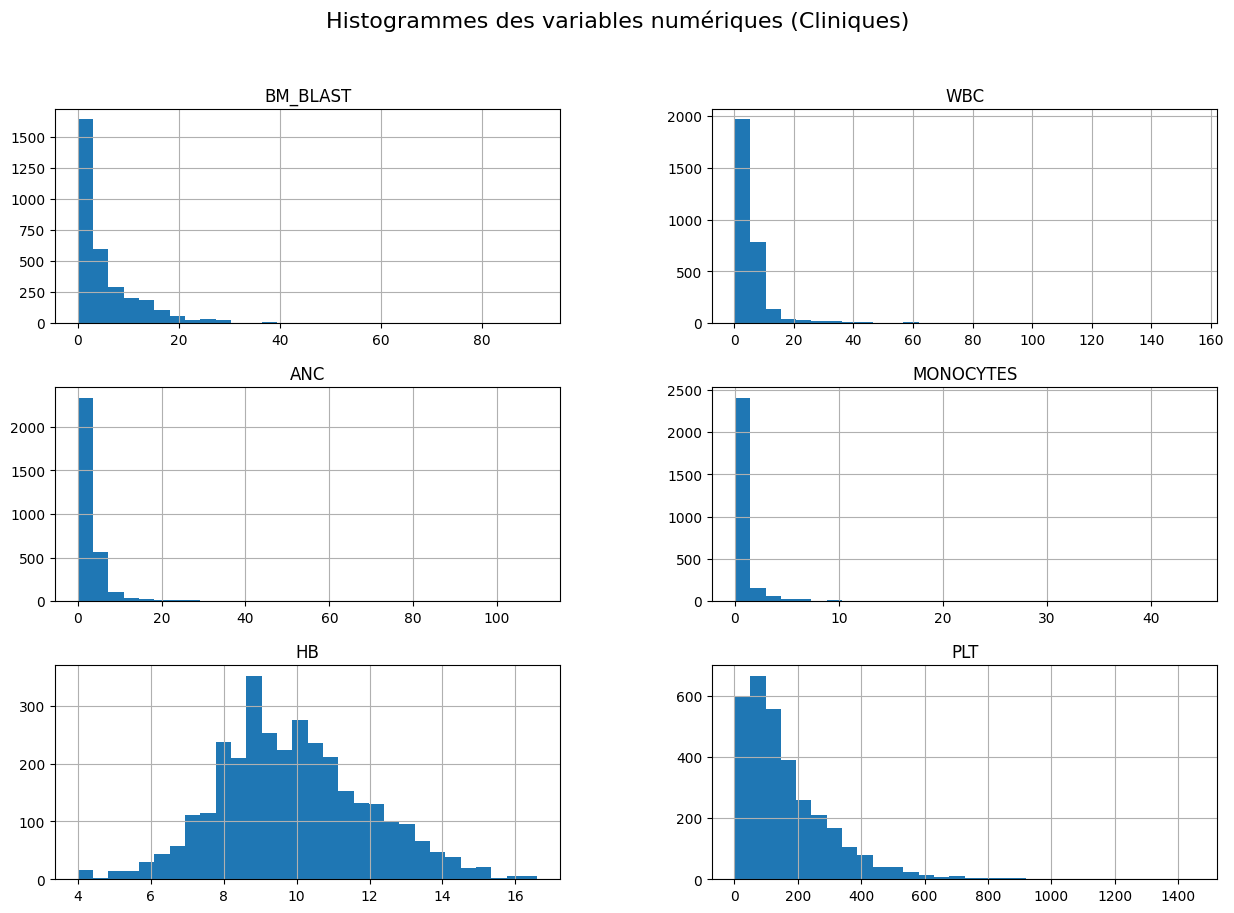


Distribution de la variable 'CENTER' :
CENTER
KI       900
DUS      455
PV       316
GESMD    246
RMCN     199
CCH      159
CGM      107
ROM      104
UOB       88
HMS       83
MUV       83
TUD       73
FUCE      73
ICO       71
FLO       68
DUTH      66
UOXF      50
HIAE      47
MSK       37
IHBT      33
VU        33
UMG       26
REL        6
Name: count, dtype: int64

Exemple de distribution de 'CYTOGENETICS' (top 10) :
CYTOGENETICS
46,xy[20]    432
46,xy        276
46,xx[20]    254
46,xx        192
46,xy[25]     61
46,xx[25]     38
46,xy[21]     33
46,xx[26]     23
46,xy[26]     21
46,xy[23]     18
Name: count, dtype: int64

Aperçu des données moléculaires :


,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0



Info sur les données moléculaires :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10935 non-null  object 
 1   CHR             10821 non-null  object 
 2   START           10821 non-null  float64
 3   END             10821 non-null  float64
 4   REF             10821 non-null  object 
 5   ALT             10821 non-null  object 
 6   GENE            10935 non-null  object 
 7   PROTEIN_CHANGE  10923 non-null  object 
 8   EFFECT          10935 non-null  object 
 9   VAF             10846 non-null  float64
 10  DEPTH           10821 non-null  float64
dtypes: float64(4), object(7)
memory usage: 939.9+ KB

Statistiques descriptives (moléculaires) :


,START,END,VAF,DEPTH
count,1.082100e+04,1.082100e+04,10846.000000,10821.000000
mean,8.078326e+07,8.078326e+07,0.305087,1051.229554
std,5.642656e+07,5.642656e+07,0.211524,552.861902
min,3.948990e+05,3.948990e+05,0.020000,16.000000
25%,3.102244e+07,3.102244e+07,0.102625,660.000000
50%,7.473296e+07,7.473296e+07,0.321250,975.000000
75%,1.152587e+08,1.152587e+08,0.442000,1353.000000
max,2.262521e+08,2.262521e+08,0.999000,7156.000000



Valeurs manquantes dans les données moléculaires :
ID                  0
CHR               114
START             114
END               114
REF               114
ALT               114
GENE                0
PROTEIN_CHANGE     12
EFFECT              0
VAF                89
DEPTH             114
dtype: int64

Statistiques sur le nombre de mutations par patient :


,mutation_count
count,3026.000000
mean,3.613681
std,2.220222
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,17.000000


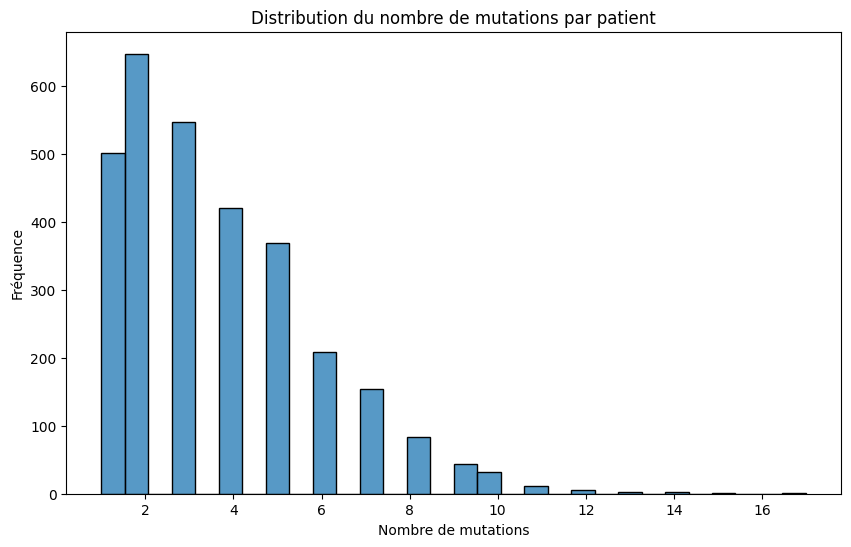

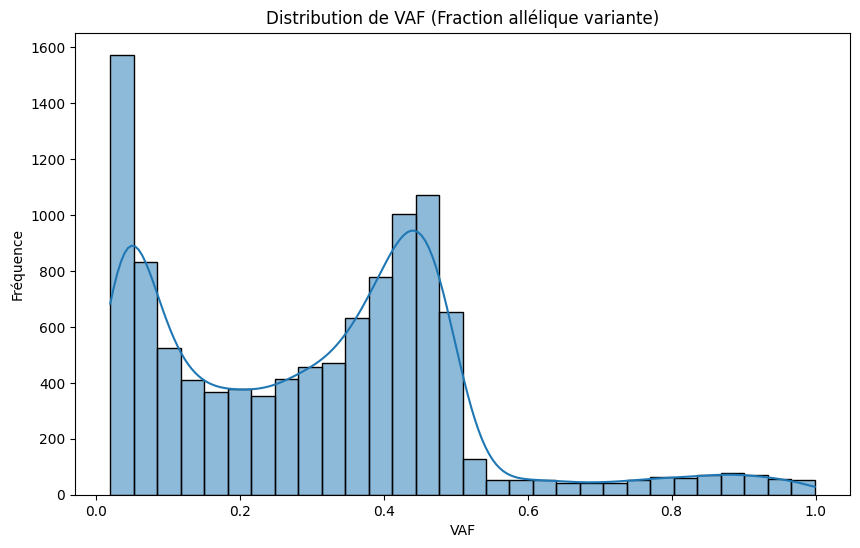


Nombre de gènes uniques dans les données moléculaires : 124

Top 10 des gènes les plus fréquents :
GENE
TET2      1663
ASXL1      951
SF3B1      775
DNMT3A     604
RUNX1      578
SRSF2      577
TP53       487
STAG2      376
U2AF1      288
EZH2       252
Name: count, dtype: int64


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lecture des fichiers CSV
clinical_df = df.copy()
molecular_df = maf_df.copy()

# Afficher la forme des datasets
print("Shape des données cliniques :", clinical_df.shape)
print("Shape des données moléculaires :", molecular_df.shape)

# ----- ANALYSE DES DONNÉES CLINIQUES -----

# Afficher les 5 premières lignes
print("\nAperçu des données cliniques :")
display(clinical_df.head())

# Informations générales sur le dataset
print("\nInfo sur les données cliniques :")
clinical_df.info()

# Statistiques descriptives pour les colonnes numériques
print("\nStatistiques descriptives (cliniques) :")
display(clinical_df.describe())

# Nombre de valeurs manquantes par colonne
print("\nValeurs manquantes dans les données cliniques :")
print(clinical_df.isnull().sum())

# Histogrammes pour les variables numériques importantes
numeric_cols = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
clinical_df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogrammes des variables numériques (Cliniques)", fontsize=16)
plt.show()

# Analyse des variables catégorielles
print("\nDistribution de la variable 'CENTER' :")
print(clinical_df['CENTER'].value_counts())

print("\nExemple de distribution de 'CYTOGENETICS' (top 10) :")
print(clinical_df['CYTOGENETICS'].value_counts().head(10))


# ----- ANALYSE DES DONNÉES MOLÉCULAIRES -----

# Afficher les 5 premières lignes
print("\nAperçu des données moléculaires :")
display(molecular_df.head())

# Informations générales sur le dataset
print("\nInfo sur les données moléculaires :")
molecular_df.info()

# Statistiques descriptives pour les variables numériques
print("\nStatistiques descriptives (moléculaires) :")
display(molecular_df.describe())

# Nombre de valeurs manquantes par colonne
print("\nValeurs manquantes dans les données moléculaires :")
print(molecular_df.isnull().sum())

# Nombre de mutations par patient
mutations_per_patient = molecular_df.groupby('ID').size().reset_index(name='mutation_count')
print("\nStatistiques sur le nombre de mutations par patient :")
display(mutations_per_patient.describe())

plt.figure(figsize=(10, 6))
sns.histplot(mutations_per_patient['mutation_count'], bins=30, kde=False)
plt.title("Distribution du nombre de mutations par patient")
plt.xlabel("Nombre de mutations")
plt.ylabel("Fréquence")
plt.show()

# Distribution de la variable VAF
plt.figure(figsize=(10, 6))
sns.histplot(molecular_df['VAF'].dropna(), bins=30, kde=True)
plt.title("Distribution de VAF (Fraction allélique variante)")
plt.xlabel("VAF")
plt.ylabel("Fréquence")
plt.show()

# Analyse de la fréquence des gènes mutés
print("\nNombre de gènes uniques dans les données moléculaires :", molecular_df['GENE'].nunique())
print("\nTop 10 des gènes les plus fréquents :")
print(molecular_df['GENE'].value_counts().head(10))

In [ ]:
from src.utilities import predict_and_save, split_data, get_method_name, score_method
from src.preprocess import process_missing_values, main_preprocess, create_entity
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
import lightgbm as lgb
import pandas as pd
from sklearn.impute import SimpleImputer

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")


GLOBAL = {
    "cox": {"model": CoxPHSurvivalAnalysis(), "run": False, "save":False, "shap": False},
    "xgb": {"model": GradientBoostingSurvivalAnalysis(), "run": True, "save":True, "shap": False},
    #"lgbm": {"model": GradientBoostingSurvivalAnalysis(), "run": False, "save":False, "shap": False},
    "rsf": {"model": RandomSurvivalForest(), "run": False, "save":False, "shap": False}
}

PARAMS = {
    "size": 0.7,
    "impute": {"strategy": "median", "sex": False},
    #"outliers": {"threshold": 0.01, "multiplier": 1.5},
    "clinical": ["logMONOCYTES", "logWBC", "logANC", "logBM_BLAST", "CYTOGENETICS"],#["CYTOGENETICS"], # Possible: ["CYTOGENETICS", "HB/PLT", "logMONOCYTES", "logWBC", "logANC"] ["BM_BLAST+WBC", "BM_BLAST/HB", "HB*PLT", "HB/num_trisomies"]
    "molecular": ["GENE"],#["END-START"], # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
    "merge": ["featuretools", "gpt"], # Possible: ["featuretools", "gpt"]
    "additional": [
        #['cadd', 'phred'],
        # ['cadd', 'rawscore'],
        # # ['cadd', 'consequence'],
        # # ['cadd', 'bstatistic'],
        # # ['cadd', 'gerp', 'n'],
        # ['cadd', 'phast_cons', 'mammalian'],
        # ['cadd', 'phylop', 'mammalian'],
        # ['snpeff', 'putative_impact'],
        # # ['snpeff', 'rank'],
        # # ['snpeff', 'total'],
         #['cadd', 'exon'],
        # # ['cadd', 'cds', 'rel_cds_pos']
        ],
    "xgb": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'n_estimators': 450,
        'subsample': 0.55,
        'max_features': 'sqrt',
        'random_state': 26
    },
    "lgbm": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'verbose': 0
    },
    "rsf": {
    'n_estimators':300,  # Nombre d'arbres dans la forêt
    'max_depth':2,
    #'min_samples_split':60,  # Nombre minimum d'échantillons requis pour splitter un nœud
    #'min_samples_leaf':40,  # Nombre minimum d'échantillons par feuille
    'max_features':None,  # Sélection aléatoire des features
    'n_jobs':-1,  # Utilisation de tous les cœurs disponibles
    }
}


data = create_entity(PARAMS)
data = main_preprocess(data, PARAMS)
X, X_eval, y = split_data(data)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - PARAMS['size']), random_state=42)
X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, X.columns, **PARAMS["impute"])

from sksurv.metrics import concordance_index_ipcw

import numpy as np
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.metrics import concordance_index_censored  # ou concordance_index_ipcw si disponible
from sklearn.metrics import make_scorer

# Définition de la grille des hyperparamètres
param_grid = {
    'max_depth': [2],
    'learning_rate': [0.05],
    'n_estimators': [450],
    'subsample': [0.55],
    'max_features': ['sqrt']
}

kfold_params = {
    'n_splits': 5,
    'shuffle': True,
    'random_state': 26
}

# Configuration du KFold (5 folds)
cv = KFold(**kfold_params)

# Initialisation du modèle
model = RandomSurvivalForest(random_state=26)



# Fonction de scoring basée sur le concordance index censored
def cindex_scorer(y_true, y_pred):
    return concordance_index_ipcw(y_true, y_true, y_pred, tau=7)[0]

# Spécifiez needs_estimator=True pour que make_scorer transmette (estimator, X, y) à votre fonction
scorer = make_scorer(cindex_scorer, greater_is_better=True)


# Configuration du GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)

# Lancement de la recherche
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur C-index :", grid_search.best_score_)

2025-03-20 11:18:34,357 featuretools - WARNING    While loading primitives via "premium_primitives" entry point, ignored primitive "DiversityScore" from "premium_primitives.diversity_score" because a primitive with that name already exists in "nlp_primitives.diversity_score"
2025-03-20 11:18:34,358 featuretools - WARNING    While loading primitives via "premium_primitives" entry point, ignored primitive "LSA" from "premium_primitives.lsa" because a primitive with that name already exists in "nlp_primitives.lsa"
2025-03-20 11:18:34,358 featuretools - WARNING    While loading primitives via "premium_primitives" entry point, ignored primitive "MeanCharactersPerSentence" from "premium_primitives.mean_characters_per_sentence" because a primitive with that name already exists in "nlp_primitives.mean_characters_per_sentence"
2025-03-20 11:18:34,358 featuretools - WARNING    While loading primitives via "premium_primitives" entry point, ignored primitive "NumberOfSentences" from "premium_primi

Traceback (most recent call last):
  File "/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/joblib_memmapping_folder_60599_78014ef551114de59246f5b5c64ce1b6_3d524b3ac99e4546acb99d3518798bf4/60599-13742796176-d7e87ec7a1a7410093595f44b30d440b.pkl'
Traceback (most recent call last):
  File "/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
    ~~~~~~~~~~~~~~~^^^^^^
KeyError: '/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/joblib_memmapping_folder_60599_78014ef551114de59246f5b5c64ce1b6_3d524b3ac99e4546acb99d3518798bf4/60599-13742796176-d7e87ec7a1a7410093595f44b30d440b.pkl'
Traceback (most re

KeyboardInterrupt: 

In [15]:
import numpy as np

inputs_ts = np.array([10, 12, 15, 20, 25])
lags = 2
# Pour lags = 1:
print(inputs_ts[lags:], inputs_ts[:-lags])
# inputs_ts[1:] = [12, 15, 20, 25]
# inputs_ts[:-1] = [10, 12, 15, 20]
resultat = np.subtract(inputs_ts[lags:], inputs_ts[:-lags])
print(resultat)  # Affichera: [ 2  3  5  5 ]

[15 20 25] [10 12 15]
[ 5  8 10]


<module 'matplotlib.pyplot' from '/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

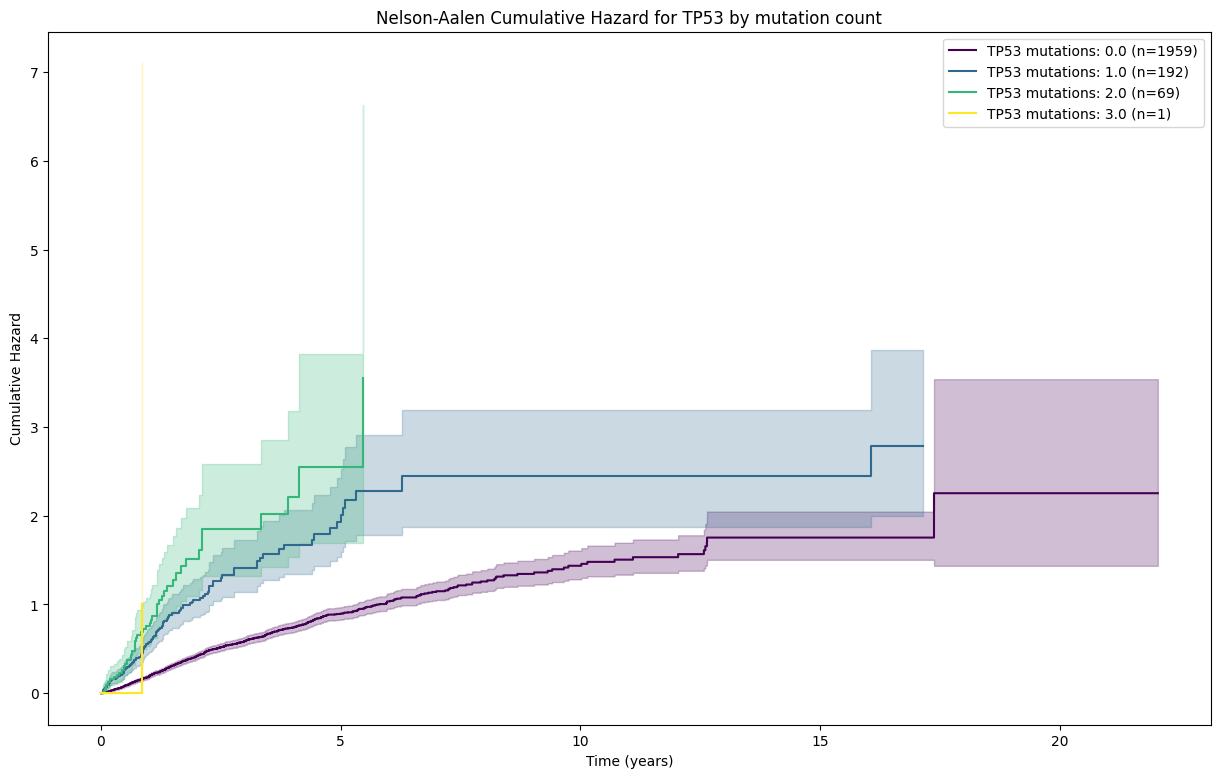

In [16]:
from src.utilities import predict_and_save, split_data, get_method_name, score_method
from src.preprocess import process_missing_values, main_preprocess, create_entity
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
import lightgbm as lgb
import pandas as pd
from sklearn.impute import SimpleImputer

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")


GLOBAL = {
    "cox": {"model": CoxPHSurvivalAnalysis(), "run": False, "save":False, "shap": False},
    "xgb": {"model": GradientBoostingSurvivalAnalysis(), "run": True, "save":True, "shap": False},
    #"lgbm": {"model": GradientBoostingSurvivalAnalysis(), "run": False, "save":False, "shap": False},
    "rsf": {"model": RandomSurvivalForest(), "run": False, "save":False, "shap": False}
}

PARAMS = {
    "size": 0.7,
    "impute": {"strategy": "median", "sex": False},
    #"outliers": {"threshold": 0.01, "multiplier": 1.5},
    "clinical": ["logMONOCYTES", "logWBC", "logANC", "logBM_BLAST", "CYTOGENETICS"],#["CYTOGENETICS"], # Possible: ["CYTOGENETICS", "HB/PLT", "logMONOCYTES", "logWBC", "logANC"] ["BM_BLAST+WBC", "BM_BLAST/HB", "HB*PLT", "HB/num_trisomies"]
    "molecular": ["GENE"],#["END-START"], # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
    "merge": ["featuretools", "gpt"], # Possible: ["featuretools", "gpt"]
    "additional": [
        #['cadd', 'phred'],
        # ['cadd', 'rawscore'],
        # # ['cadd', 'consequence'],
        # # ['cadd', 'bstatistic'],
        # # ['cadd', 'gerp', 'n'],
        # ['cadd', 'phast_cons', 'mammalian'],
        # ['cadd', 'phylop', 'mammalian'],
        # ['snpeff', 'putative_impact'],
        # # ['snpeff', 'rank'],
        # # ['snpeff', 'total'],
         #['cadd', 'exon'],
        # # ['cadd', 'cds', 'rel_cds_pos']
        ],
    "xgb": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'n_estimators': 450,
        'subsample': 0.55,
        'max_features': 'sqrt',
        'random_state': 26
    },
    "lgbm": {
        'max_depth': 2,
        'learning_rate': 0.05,
        'verbose': 0
    },
    "rsf": {
    'n_estimators':300,  # Nombre d'arbres dans la forêt
    'max_depth':2,
    #'min_samples_split':60,  # Nombre minimum d'échantillons requis pour splitter un nœud
    #'min_samples_leaf':40,  # Nombre minimum d'échantillons par feuille
    'max_features':None,  # Sélection aléatoire des features
    'n_jobs':-1,  # Utilisation de tous les cœurs disponibles
    }
}


data = create_entity(PARAMS)
data = main_preprocess(data, PARAMS)
X, X_eval, y = split_data(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - PARAMS['size']), random_state=42)
X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, X.columns, **PARAMS["impute"])

X_train = pd.DataFrame(data=X_train, columns=X.columns)

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
def plot_gene_survival_curves(X, y_train, gene_name, max_mutations=None):
    from lifelines import NelsonAalenFitter
    
    # Convertir y_train en DataFrame s'il ne l'est pas déjà
    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train, columns=['event', 'time'])
    
    survival_times = y_train['time']
    event_observed = y_train['event']
    
    # Obtenir les valeurs uniques du nombre de mutations
    unique_counts = sorted(X[f'gene_{gene_name}'].unique())
    if max_mutations:
        # Grouper les valeurs supérieures à max_mutations
        X[f'gene_{gene_name}_grouped'] = X[f'gene_{gene_name}'].apply(
            lambda x: f"{max_mutations}+" if x > max_mutations else str(x)
        )
    
    # Initialize Nelson-Aalen fitter
    naf = NelsonAalenFitter()
    
    plt.figure(figsize=(15, 9))
    
    # Utiliser un colormap pour différencier les courbes
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_counts)))
    
    for idx, count in enumerate(unique_counts):
        mask = X[f'gene_{gene_name}'] == count
        if mask.sum() > 0:
            naf.fit(
                survival_times[mask],
                event_observed[mask],
                label=f"{gene_name} mutations: {count}"
            )
            naf.plot_cumulative_hazard(color=colors[idx])
    
    plt.title(f"Nelson-Aalen Cumulative Hazard for {gene_name} by mutation count")
    plt.xlabel("Time (years)")
    plt.ylabel("Cumulative Hazard")
    
    # Correction ici : conversion en float avant la comparaison
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [f"{label} (n={sum(X[f'gene_{gene_name}'] == float(label.split(': ')[1]))})"
             for label in labels]
    plt.legend(handles, labels)
    
    return plt

plot_gene_survival_curves(X_train, y_train, "TP53", max_mutations=3)


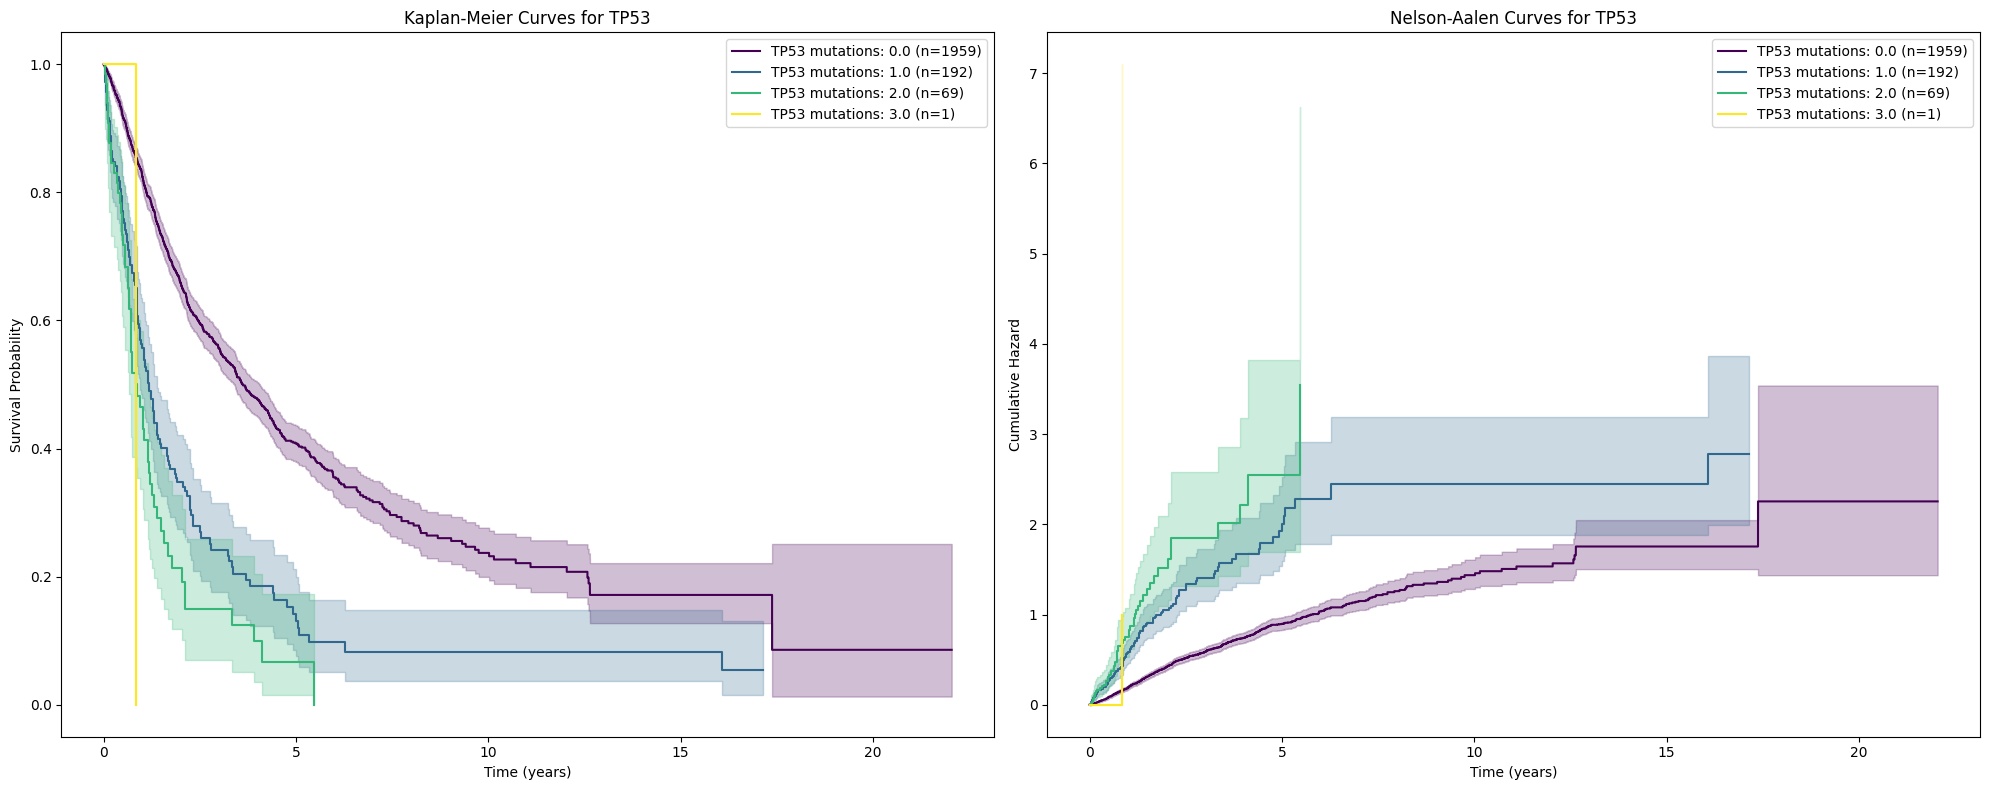

In [ ]:
def plot_survival_curves(X, y_train, gene_name, max_mutations=None):
    """
    Trace les courbes de Kaplan-Meier et Nelson-Aalen pour un gène donné
    """
    from lifelines import KaplanMeierFitter, NelsonAalenFitter
    
    # Convertir y_train en DataFrame si nécessaire
    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train, columns=['event', 'time'])
    
    survival_times = y_train['time']
    event_observed = y_train['event']
    
    # Obtenir les valeurs uniques du nombre de mutations
    unique_counts = sorted(X[f'gene_{gene_name}'].unique())
    
    # Créer une figure avec deux sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Utiliser un colormap pour différencier les courbes
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_counts)))
    
    # Initialiser les estimateurs
    kmf = KaplanMeierFitter()
    naf = NelsonAalenFitter()
    
    # Tracer les courbes pour chaque nombre de mutations
    for idx, count in enumerate(unique_counts):
        mask = X[f'gene_{gene_name}'] == count
        if mask.sum() > 0:
            # Nelson-Aalen
            naf.fit(
                survival_times[mask],
                event_observed[mask],
                label=f"{gene_name} mutations: {count}"
            )
            naf.plot_cumulative_hazard(ax=ax2, color=colors[idx])
    
    # Configurer le graphique Nelson-Aalen
    ax2.set_title(f"Nelson-Aalen Curves for {gene_name}")
    ax2.set_xlabel("Time (years)")
    ax2.set_ylabel("Cumulative Hazard")
    
    # Ajouter les tailles d'échantillon dans les légendes
    for ax in [ax1, ax2]:
        handles, labels = ax.get_legend_handles_labels()
        labels = [f"{label} (n={sum(X[f'gene_{gene_name}'] == float(label.split(': ')[1]))})"
                 for label in labels]
        ax.legend(handles, labels)
    
    plt.tight_layout()
    return fig

# Utilisation
plot_survival_curves(X_train, y_train, "TP53", max_mutations=3)
plt.show()

In [6]:
X['gene_BCOR']

ID
P132697    0.0
P132698    0.0
P116889    0.0
P132699    0.0
P132700    0.0
          ... 
P121826    0.0
P121827    0.0
P121830    0.0
P121853    0.0
P121834    0.0
Name: gene_BCOR, Length: 3173, dtype: float64

In [30]:
for i, params in enumerate(grid_search.cv_results_['params']):
    mean_score = grid_search.cv_results_['mean_test_score'][i]
    std_score = grid_search.cv_results_['std_test_score'][i]
    print(f"Paramètres: {params} => Score moyen: {mean_score:.4f} ± {std_score:.4f}")

Paramètres: {'learning_rate': 0.049, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.55} => Score moyen: 0.7058 ± 0.0319
Paramètres: {'learning_rate': 0.049, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.54} => Score moyen: 0.7063 ± 0.0321
Paramètres: {'learning_rate': 0.049, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.56} => Score moyen: 0.7065 ± 0.0328
Paramètres: {'learning_rate': 0.049, 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 100, 'subsample': 0.55} => Score moyen: 0.7023 ± 0.0313
Paramètres: {'learning_rate': 0.049, 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 100, 'subsample': 0.54} => Score moyen: 0.7023 ± 0.0316
Paramètres: {'learning_rate': 0.049, 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 100, 'subsample': 0.56} => Score moyen: 0.7019 ± 0.0309
Paramètres: {'learning_rate': 0.049, 'max_depth': 2, 'max_features': None, 'n_estimators': 100, 'subsample

In [36]:
np.log2(102)/102

0.06541593472521073